# General Index Processing and Modeling Optimization Test
Small scale optimization of general index data embedding and modeling.

---
Created 6/3/22 by Ian Hay   
Updated 12/19/22

### Background
---


### Imports
Dependencies

---
[Python 3.8+](https://www.python.org/downloads/release/python-380/)    
[Pandas](https://pandas.pydata.org/)   
[NumPy](https://numpy.org/)    
[NetworkX](https://networkx.org/)  
[pyvis](https://pyvis.readthedocs.io/en/latest/install.html)   
[scikit-learn](https://scikit-learn.org/stable/index.html)  
[seaborn](https://seaborn.pydata.org/)  
[nltk](https://www.nltk.org/)   
[gensim](https://pypi.org/project/gensim/)  
[spacy](https://pypi.org/project/spacy/)    
[BERTopic](https://pypi.org/project/bertopic/)  

In [3]:
# recommended to create new virtual environment:
# conda create -n generalindexenv -c conda-forge python=3.8 pandas seaborn nltk gensim numpy scikit-learn spacy hdbscan pyvis bertopic
# conda activate generalindexenv
# (if in vscode) conda install -n generalindexenv ipykernel --update-deps --force-reinstall

In [1]:
from time import time
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import re
import nltk
import ssl
import gensim
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations
from pyvis import network as net
from pyvis.network import Network
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
import hdbscan
# from top2vec import Top2Vec
# from bertopic import BERTopic
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif

/Users/ian/opt/anaconda3/envs/generalindexenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# run in  environment: 
# python -m spacy download en_core_web_sm

In [3]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")


### - https://course.spacy.io/en/chapter3

from spacy.language import Language

@Language.component("custom_component")
def custom_component_function(doc):
    # Do something to the doc here
    return doc

# nlp.add_pipe("custom_component")

###


print(nlp.pipeline)

[nltk_data] Downloading package stopwords to /Users/ian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec object at 0x7fc53733cfa0>), ('tagger', <spacy.pipeline.tagger.Tagger object at 0x7fc53733c2e0>), ('parser', <spacy.pipeline.dep_parser.DependencyParser object at 0x7fc5335627b0>), ('attribute_ruler', <spacy.pipeline.attributeruler.AttributeRuler object at 0x7fc5373e2440>), ('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer object at 0x7fc5373ec200>), ('ner', <spacy.pipeline.ner.EntityRecognizer object at 0x7fc5349d0430>)]


### Functions

In [4]:
# Data Processing -------------------------------------------------------------------------------------------

def getDocColumn(df, column, newColumnName):
    """
    Given a dataframe and a column of datatype list, constructs
    a new column newColumnName with the list joined into a single
    string and items separated by spaces (" ").
    """
    strDict = {}
    for row in range(len(df)):
        text = ". ".join(df.iloc[row][column])
        text = text + "."
        strDict[df.index[row]] = text
    dfStr = pd.Series(strDict, name=newColumnName)
    df[newColumnName] = dfStr

def getBagOfWordsDF(df, docColumn):
    """
    """
    countvec = CountVectorizer()
    X = countvec.fit_transform(df[docColumn])
    dfBOW = pd.DataFrame(X.toarray(),columns=countvec.get_feature_names_out())
    dfBOW.set_index(df.index, inplace=True)
    return dfBOW

def getNounsAndVerbs(df, column, newColumnName):
    """
    Utilizes Spacy to extract nouns and verbs from ngrams
    and build a new column with only these terms.
    """
    nounAndVerbDict = {}
    for row in range(len(df)):
        text = ". ".join(df.iloc[row][column])
        doc = nlp(text)
        nounList = [chunk.text for chunk in doc.noun_chunks]
        verbList = [token.lemma_ for token in doc if token.pos_ == "VERB"]
        nounAndVerbDict[df.index[row]] = nounList + verbList
    dfNounAndVerb = pd.Series(nounAndVerbDict, name=newColumnName)
    df[newColumnName] = dfNounAndVerb

def partOfSpeechTagging(texts, POS=["NOUN", "ADJ", "ADV", "VERB"]):
    """
    https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#16buildingldamalletmodel
    """
    textTagged = []
    for text in texts:
        doc = nlp(text)
        text_ = [token.lemma_ for token in doc if token.pos_ in POS]
        textTagged.append(" ".join(text_))
    return textTagged

def removeStopWords(texts):
    """
    Takes in texts (words in a single string separated by spaces).
    https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe
    """
    textParsed = []
    from nltk.corpus import stopwords
    _stopWords = stopwords.words("english")
    _stopWords.extend(["-pron-", "pron"]) # these words appears in many ngrams without apparent meaning
    textParsed = texts.apply(lambda x: " ".join([word for word in x.split() if word not in (list(_stopWords))]))
    return textParsed

def getUniqueWordsColumn(df, column, newColumnName, nonWords=[]):
    """
    Given a dataframe and column, constructs a new column with name newColumnName
    of the unique words in  df[column].
    The object in  df[column]  must be a list of strings.
    Returns the updated dataframe.
    """

    ### deprecated ###

    df[newColumnName] = df[column]
    for row in range(len(df[newColumnName])):
        df[newColumnName][row] = df[column].iloc[row]
        string_list = []
        for string in df[newColumnName].iloc[row]:
            string_list.append(string.split(" ")) # splits words into list of individual word strings
        string_list = list(itertools.chain(*string_list)) # concatenates nested list into 1D list
        string_list = list(set(string_list)) # grabs only unique string items
        for nonword in nonWords:
            if nonword in string_list:
                string_list.remove(nonword)
        df.loc[newColumnName].iloc[row] = string_list
    return df

def buildAdjacencyMatrixByColumn(df, column):
    """
    Given a dataframe and a column, constructs an adjacency matrix
    of size [n x n] where  n  is the number of rows of the dataframe.
    The adjacency matrix edge weights represent the number of similar elements.
    The datatype in  df[column]  must be a list.
    """
    n = len(df[column])
    adjMatrix = np.zeros((n, n))
    for n1 in range(n):
        ngram1 = df[column].iloc[n1]
        for n2 in range(n):
            ngram2 = df[column].iloc[n2]
            numSimilar = numSimilarStrings(ngram1, ngram2)
            if n1 != n2 & numSimilar > 0: # removes recursive edges
                adjMatrix[n1][n2] = numSimilar 
    return adjMatrix

def buildAdjacencyListByColumn(df, column):
    """
    Given a dataframe and a column, constructs an adjacency list
    as a nestd dictionary with  n  keys in the outermost dict, where
    n  is the number of rows in the dataframe.
    The adjacency list edge weights represent the number of similar elements.
    The datatype in  df[column]  must be a list.
    """
    n = len(df[column])

    adjDict = {} # consider using the hash to represent nodes instead of numbers
    for n1 in range(n):

        nodeDict = {}
        ngram1 = df[column].iloc[n1]
        for n2 in range(n):
            ngram2 = df[column].iloc[n2]
            numSimilar = numSimilarStrings(ngram1, ngram2)
            if n1 != n2 & numSimilar > 0: # removes recursive edges
                nodeDict[n2] = {"weight" : numSimilar} # https://networkx.org/documentation/stable/reference/generated/networkx.convert.from_dict_of_dicts.html
        adjDict[n1] = nodeDict

    return adjDict

def buildAdjacencyMatrixByCoOccurence(dfBOW):
    """
    """
    X = np.array(dfBOW.values)
    coocc = np.dot(X.T, X)
    np.fill_diagonal(coocc, 0)
    return coocc

def buildDocVectorMatrixByColumn(df, docColumn):
    """
    Given a dataframe and a column storing documents,
    trains a gensim doc2vec model and outputs
    the vector matrix.
    """
    def read_corpus(documents):
        for i, plot in enumerate(documents):
            yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(plot, max_len=30), [i])

    train_corpus = list(read_corpus(df[docColumn]))
    model = gensim.models.doc2vec.Doc2Vec(vector_size=5, min_count=2, epochs=55) # hyperparameters
    model.build_vocab(train_corpus)
    model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)
    docVectors = model.dv.vectors
    return docVectors

def buildAdjacencyMatrixByCosineSimilarity(vecMatrix):
    """
    Given a vector matrix, computes the cosine similarity score
    between rows of the matrix and stores the values in an
    adjacency matrix.
    """
    n = len(vecMatrix)
    cosSimMatrix = np.zeros((n,n))
    for row in range(n):
        a = vecMatrix[row]
        for otherRow in range(n):
            b = vecMatrix[otherRow]
            cosSimMatrix[row][otherRow] = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    np.fill_diagonal(cosSimMatrix, 0)
    return cosSimMatrix

In [5]:
# Utility --------------------------------------------------------------------------------------------------

def loadTextFileIntoDataframe(filepath, columns, splittingChar="\t", encoding="utf8"):
    """
    Opens the given filepath into a pandas dataframe.
    Splits the list by the denoted character, by default tab.
    Returns a pandas dataframe.
    """
    with open(filepath, encoding="utf8") as file:
        data = file.readlines()
    df = pd.DataFrame(columns=columns)
    for line in data:
        lineSplit = [line.split(splittingChar)]
        if len(lineSplit[0]) < len(columns):
            for x in range(len(columns) - len(lineSplit[0])):
                lineSplit[0].append("0")
        lineDF = pd.DataFrame(lineSplit, columns=columns)
        df = pd.concat([df, lineDF], axis=0, ignore_index=True)
    return df

def numSimilarStrings(stringList1, stringList2):
    """
    Given two lists of strings, returns the number of strings they both share.
    In other words, the size of the subset intersection of stringList1 and stringList2.
    """

    # is there a faster way to do this with sets?

    count = 0
    for string in stringList1:
        if string in stringList2:
            count = count + 1
    return count

def subtractListsOfInts(_list1, _list2):
    """
    Given two lists of items, returns a list of items
    in _list1 and not in _list2.
    Utilizes collections.Counter
    Returns a list of items.

    https://stackoverflow.com/questions/2070643/subtracting-two-lists-in-python
    """
    _set1 = Counter(_list1)
    _set2 = Counter(_list2)
    _set1_2 = _set1 - _set2
    return list(_set1_2.elements())

def cosineSimilarityNumMostSimilar(model, word, target_list, num):
    """
    https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92
    """
    cosine_dict ={}
    word_list = []
    a = model[word]
    for item in target_list :
        if item != word :
            b = model [item]
            cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
            cosine_dict[item] = cos_sim
    dist_sort=sorted(cosine_dict.items(), key=lambda dist: dist[1],reverse = True) ## in descending order 
    for item in dist_sort:
        word_list.append((item[0],  item[1]))
    return word_list[0:num]

def standardizeDataColumn(df, column, newColumnName):
    """
    Standardizes the column of the dataframe df.
    Adds the new column newColumnName to the dataframe inplace.
    Utilizes SKLearn.preprocessing.standardscaler.
    Mean is 0, variance is 1
    """
    scaler = StandardScaler()
    scaledSeries = pd.Series(np.reshape(scaler.fit_transform(np.array(df[column]).reshape(-1, 1)), (-1)), name=newColumnName, index=df.index)
    scaledSeries = scaledSeries + 1 # adding 1 scales most (~98%) to be in range [0, 2] for graphing purposes
    df[newColumnName] = scaledSeries


In [6]:
# Visualization -------------------------------------------------------------------------------------------

def visualizeNetworkHTML(_graph, _filename, _width="1920px", _height="1080px", _physics=False):
    """
    Given a NetworkX graph and the filename to save to, builds an HTML
    graph of that network. Optional parameters are width and height of graph.
    Uses pyvis to build an interactive HTML graph of a NetworkX graph.
    Uses NetworkX for graph storage.
    """
    _net = Network(width=_width, height=_height, notebook=True)
    _net.toggle_physics(_physics)
    _net.barnes_hut()
    _net.from_nx(_graph)
    _net.show(_filename)

def plot_top_words_one_topic(model, feature_names, n_top_words, title):
    """
    https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
    """
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        plt.barh(top_features, weights, height=0.7)
        plt.tick_params(axis="both", which="major", labelsize=12)
        plt.suptitle(title, fontsize=25)
    plt.show()

def plot_top_words(model, feature_names, n_top_words, title, n_topics):
    """
    https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
    """
    fig, axes = plt.subplots(1, n_topics, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

def drawNetworkgraph(networkx_graph,notebook=True,output_filename='graph.html',show_buttons=True,only_physics_buttons=False,
                height=None,width=None,bgcolor=None,font_color=None,pyvis_options=None):
    """
    https://gist.github.com/maciejkos/e3bc958aac9e7a245dddff8d86058e17
    
    This function accepts a networkx graph object,
    converts it to a pyvis network object preserving its node and edge attributes,
    and both returns and saves a dynamic network visualization.
    Valid node attributes include:
        "size", "value", "title", "x", "y", "label", "color".
        (For more info: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_node)
    Valid edge attributes include:
        "arrowStrikethrough", "hidden", "physics", "title", "value", "width"
        (For more info: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_edge)
    Args:
        networkx_graph: The graph to convert and display
        notebook: Display in Jupyter?
        output_filename: Where to save the converted network
        show_buttons: Show buttons in saved version of network?
        only_physics_buttons: Show only buttons controlling physics of network?
        height: height in px or %, e.g, "750px" or "100%
        width: width in px or %, e.g, "750px" or "100%
        bgcolor: background color, e.g., "black" or "#222222"
        font_color: font color,  e.g., "black" or "#222222"
        pyvis_options: provide pyvis-specific options (https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.options.Options.set)
    """

    # make a pyvis network
    network_class_parameters = {"notebook": notebook, "height": height, "width": width, "bgcolor": bgcolor, "font_color": font_color}
    pyvis_graph = net.Network(**{parameter_name: parameter_value for parameter_name, parameter_value in network_class_parameters.items() if parameter_value})

    # for each node and its attributes in the networkx graph
    for node,node_attrs in networkx_graph.nodes(data=True):
        pyvis_graph.add_node(node,**node_attrs)

    # for each edge and its attributes in the networkx graph
    for source,target,edge_attrs in networkx_graph.edges(data=True):
        # if value/width not specified directly, and weight is specified, set 'value' to 'weight'
        if not 'value' in edge_attrs and not 'width' in edge_attrs and 'weight' in edge_attrs:
            # place at key 'value' the weight of the edge
            edge_attrs['value']=edge_attrs['weight']
        # add the edge
        pyvis_graph.add_edge(source,target,**edge_attrs)

    # turn buttons on
    if show_buttons:
        if only_physics_buttons:
            pyvis_graph.show_buttons(filter_=['physics'])
        else:
            pyvis_graph.show_buttons()

    # pyvis-specific options
    if pyvis_options:
        pyvis_graph.set_options(pyvis_options)

    # return and also save
    return pyvis_graph.show(output_filename)

def display_closestwords_tsnescatterplot(model, word, size):
    """
    https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92
    """
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]
    close_words = model.similar_by_word(word)
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
            
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
        plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
        plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
        plt.show()


### Building Dataframe and Pre-Processing Data

In [9]:
# hard coded things
columnListNGrams = ["hash", "ngram", "ngram_lc", "ngram_tokens", "ngram_count", "term_freq", "doc_count", "date_added"]
columnListKeywords = ["hash", "keywords", "keywords_lc", "keyword_tokens", "keyword_score", "doc_count", "insert_date"]

filepathhundredThousand = "data/doc_ngrams_0_1M_ngrams.txt"

In [10]:
# load test files into dataframe
indexCol = columnListNGrams[0]

df_raw = pd.read_csv(
                    filepathhundredThousand,
                    names=columnListNGrams,
                    sep="\t",
                    index_col=0
                    )

print(df_raw.shape)
df_raw.head()

/var/folders/96/s8vtyz9x38v4szdk13kx7g6w0000gn/T/ipykernel_68637/692732523.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(


(914815, 7)


,ngram,ngram_lc,ngram_tokens,ngram_count,term_freq,doc_count,date_added
hash,,,,,,,
0000e0c5b1b8dbbfe2c6491841d1e5fa3d2d317f,MCaIV,mcaiv,1,1.0,0.000959,1,\N
0000e0c5b1b8dbbfe2c6491841d1e5fa3d2d317f,resistant,resistant,1,1.0,0.000959,1,\N
0000e0c5b1b8dbbfe2c6491841d1e5fa3d2d317f,vitro,vitro,1,3.0,0.002876,1,\N
0000e0c5b1b8dbbfe2c6491841d1e5fa3d2d317f,H4IIE,h4iie,1,3.0,0.002876,1,\N
0000e0c5b1b8dbbfe2c6491841d1e5fa3d2d317f,"DU145,ONCsensitive","du145,oncsensitive",1,1.0,0.000959,1,\N


In [11]:
df_raw["ngram_lc"] = df_raw["ngram_lc"].astype(str) 
# even though it is an object dtype already,
# some numbers are causing errors and being treated as floats
df_raw.dtypes

ngram            object
ngram_lc         object
ngram_tokens      int64
ngram_count     float64
term_freq       float64
doc_count        object
date_added       object
dtype: object

In [12]:
texts = df_raw["ngram_lc"]
textTagged = []

from nltk.corpus import stopwords
_stopWords = stopwords.words("english")
textTagged = texts.apply(lambda x: " ".join([word for word in x.split() if word not in (list(_stopWords))])).to_list()

textPOS = []

POS=["PROPN", "NOUN", "ADJ", "ADV", "VERB", "X"] #: X denotes when spacy fails to find its part-of-speech
# i have noticed some important words being removed for not being identified

textPipe = nlp.pipe(textTagged, batch_size=10, n_process=4)
# is not keeping track of hash (to my knowledge), may want to group docs beforehand
# or update the spacy pipeline

# doing this manually or in pandas is gonna be a large bottleneck, consider keeping
# everything in the generator

df_raw.pipe()


In [13]:
# process data columns
df_raw["ngram_lc_tagged"] = partOfSpeechTagging(df_raw["ngram_lc"])
df_raw["ngram_lc_tagged"] = removeStopWords(df_raw["ngram_lc_tagged"])
df = df_raw.groupby(indexCol).agg(list)

yakeScoreCol = columnListNGrams[5]
for n in range(len(df)):
    term_freq_list = df[yakeScoreCol].iloc[n]
    df[yakeScoreCol].iloc[n] = term_freq_list[0]
    df["topic"].iloc[n] = df["topic"].iloc[n][0]
    if (len(df["ngram_lc_tagged"].iloc[n])) == 0: # if there are no noun/verb phrases from spacy preprocessing
        df["ngram_lc_tagged"][n] = df["ngram_lc"].iloc[n] # replace it with the lowercase ngram(s)

    if (n % 1000 == 0):
        print("completed " + str(n) + " rows\n")
df[yakeScoreCol] = df[yakeScoreCol].astype(float)

standardizeDataColumn(df, yakeScoreCol, "normalized_term_freq")
getDocColumn(df, "ngram_lc_tagged", "ngram_lc_tagged_doc")
getDocColumn(df, "ngram_lc", "ngram_lc_doc")

# save the dataframe for later use
df.to_csv("test_data_100K_processed.csv")

df.head()

ValueError: [E1041] Expected a string, Doc, or bytes as input, but got: <class 'float'>

In [8]:
# read the processed data CSV
df = pd.read_csv("test_data_100K_processed.csv")
df.set_index("hash", inplace=True)
# https://stackoverflow.com/questions/63200863/how-to-convert-the-datatype-of-a-column-from-string-to-list-in-pandas
df['ngram'] = df['ngram'].apply(lambda cell:
                                      ''.join(c for c in cell if c not in "'[]").split(', '))
df['ngram_lc'] = df['ngram_lc'].apply(lambda cell:
                                      ''.join(c for c in cell if c not in "'[]").split(', '))
df['ngram_lc_tagged'] = df['ngram_lc_tagged'].apply(lambda cell:
                                      ''.join(c for c in cell if c not in "'[]").split(', '))
df.head()

,ngram,ngram_lc,ngram_tokens,ngram_count,term_freq,doc_count,date_added,topic,ngram_lc_tagged,standardized_term_freq,ngram_lc_tagged_doc,ngram_lc_doc,topic_num
hash,,,,,,,,,,,,,
3002e8a37ec9d00a67bdf0004b8628c35d72068d,"[antediluvian, antediluvian humanity]","[antediluvian, antediluvian humanity]","['1', '2']","['1', '1']",0.000010,"['1', '1']","['\\N\n', '\\N\n']",antediluvian,"[antediluvian, antediluvian humanity]",-0.654965,antediluvian. antediluvian humanity.,antediluvian. antediluvian humanity.,1
3005b3bf055ddcb3c25e4742a72ee16728934efd,"[antediluvian, antediluvian refrain, follow by...","[antediluvian, antediluvian refrain, follow by...","['1', '2', '4', '5']","['1', '1', '1', '1']",0.000281,"['1', '1', '1', '1']","['\\N\n', '\\N\n', '\\N\n', '\\N\n']",antediluvian,"[antediluvian, antediluvian refrain, follow an...",-0.004052,antediluvian. antediluvian refrain. follow ant...,antediluvian. antediluvian refrain. follow by ...,1
3005ebfe5508340797dbfcce8454f3d3f6f76eb1,"[antediluvian, antediluvian dream, cave of -PR...","[antediluvian, antediluvian dream, cave of -pr...","['1', '2', '4', '5', '5']","['1', '1', '1', '1', '1']",0.000091,"['1', '1', '1', '1', '1']","['2021-09-03\n', '2021-09-03\n', '2021-09-03\n...",antediluvian,"[antediluvian, antediluvian dream, cave antedi...",-0.459385,antediluvian. antediluvian dream. cave antedil...,antediluvian. antediluvian dream. cave of -pro...,1
30064ae161de1e9a96992be108c195796f13e72a,"[Hennig86 program, routine in the Hennig86, ro...","[hennig86 program, routine in the hennig86, ro...","['2', '4', '5', '1']","['1', '1', '1', '1']",0.000198,"['1', '1', '1', '1']","['\\N\n', '\\N\n', '\\N\n', '\\N\n']",hennig86,"[hennig86 program, routine hennig86, routine h...",-0.202622,hennig86 program. routine hennig86. routine he...,hennig86 program. routine in the hennig86. rou...,0
30136ab3788ab8e8be6b939901ec669a41ef896a,[antediluvian],[antediluvian],['1'],['1'],0.000051,['1'],['\\N\n'],antediluvian,[antediluvian],-0.556359,antediluvian.,antediluvian.,1


In [9]:
# creates a list of all words that appear in the dataset

from itertools import chain
masterTermList = []
for eachList in df["ngram_lc"].values:
    splitList = []
    for string in eachList:
        splitList.append(string.split(" "))
    masterTermList.append(splitList)
firstNest = list(chain(*masterTermList))
secondNest = list(chain(*firstNest))
masterTerms = list(dict.fromkeys(secondNest))

In [10]:
# count number of times each word appears in an ngram
dfBoW = getBagOfWordsDF(df, "ngram_lc_doc")
dfBoWTag = getBagOfWordsDF(df, "ngram_lc_tagged_doc")
wordCountDict = {}
wordCountDictTag = {}
for column in dfBoW.columns:
    wordCountDict[column] = np.sum(dfBoW[column])
for column in dfBoWTag.columns:
    wordCountDictTag[column] = np.sum(dfBoWTag[column])

### Building Embeddings

##### Count Vectorizer

In [30]:
# build count vectorizer
xCol = "ngram_lc_tagged_doc"
doc = []
vectorizer = CountVectorizer()

print("Building Corpus...")
t0 = time()
count = 0
for hash in df.index:
    hashDoc = df.loc[hash][xCol]
    doc.append(hashDoc)
    count = count + 1
countVec = vectorizer.fit_transform(doc).toarray() # sparse matrix of token counts
print("done in %0.3fs.\n" % (time() - t0))

Building Corpus...
done in 0.075s.



##### TF-IDF

In [24]:
# build TF-IDF matrix
print("Building Corpus...")
t0 = time()
docColumn = "ngram_lc_tagged_doc"
tfidf_vectorizer = TfidfVectorizer()
TfIdf = tfidf_vectorizer.fit_transform(df[docColumn])
terms = list(tfidf_vectorizer.get_feature_names_out())
print("done in %0.3fs.\n" % (time() - t0))

Building Corpus...
done in 0.010s.



##### Word2Vec Embedding

In [34]:
# https://stackoverflow.com/questions/59711928/how-can-i-calculate-the-coherence-score-in-the-sklearn-implementation-of-nmf
class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok )
            yield tokens

In [35]:
# build and save w2v models
train_corpus = list(df["ngram_lc_tagged_doc"])
docgen = TokenGenerator( train_corpus, stopwords=[] )
# the model has v dimensions, the minimum document-term frequency is m
vector_sizes = [10,15,20,25,30,40,50,60,80,100,150,200,250,300,400,500]
min_count=[1,2,3,4,5]
sg=[0,1] # skip-gram

######### need to optimize these and more hyperparameters ##########
w2v_model = gensim.models.Word2Vec(docgen, vector_size=20, min_count=3, sg=1)
w2v_vectors = w2v_model.wv.vectors

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


##### Doc2Vec Embedding

In [15]:
# https://stackoverflow.com/questions/48953871/gensim-doc2vec-access-vectors-by-document-author
def read_corpus(documents):
    for i, plot in enumerate(documents):
        yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(plot, max_len=30), [i])

In [16]:
# build and save doc2vec models
train_corpus = list(read_corpus(df["ngram_lc_doc"]))
vector_sizes = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]
min_count=[1,2,3,4,5]
epochs = [5,10,20,40]

######### need to optimize these and more hyperparameters ##########
model = gensim.models.doc2vec.Doc2Vec(vector_size=5, min_count=2, epochs=55)
model.build_vocab(train_corpus)
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)
docVectors = model.dv.vectors

##### Ngram2Vec embedding

In [26]:
# to do
# https://aclanthology.org/D17-1023/
# https://github.com/zhezhaoa/ngram2vec

##### Tok2Vec Embedding

In [ ]:
# to do
# 

##### BERT Embedding

In [ ]:
# to do
# 

##### HuggingFace Embedding(s)

In [ ]:
# to do: https://huggingface.co/models

### Evaluating Embeddings

In [ ]:
# to do
# https://www.cambridge.org/core/journals/apsipa-transactions-on-signal-and-information-processing/article/evaluating-word-embedding-models-methods-and-experimental-results/EDF43F837150B94E71DBB36B28B85E79

### Models

##### LDA Model
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#16buildingldamalletmodel "18. Finding the dominant topic in each sentence"

Fitting Corpus...
done in 0.935s.



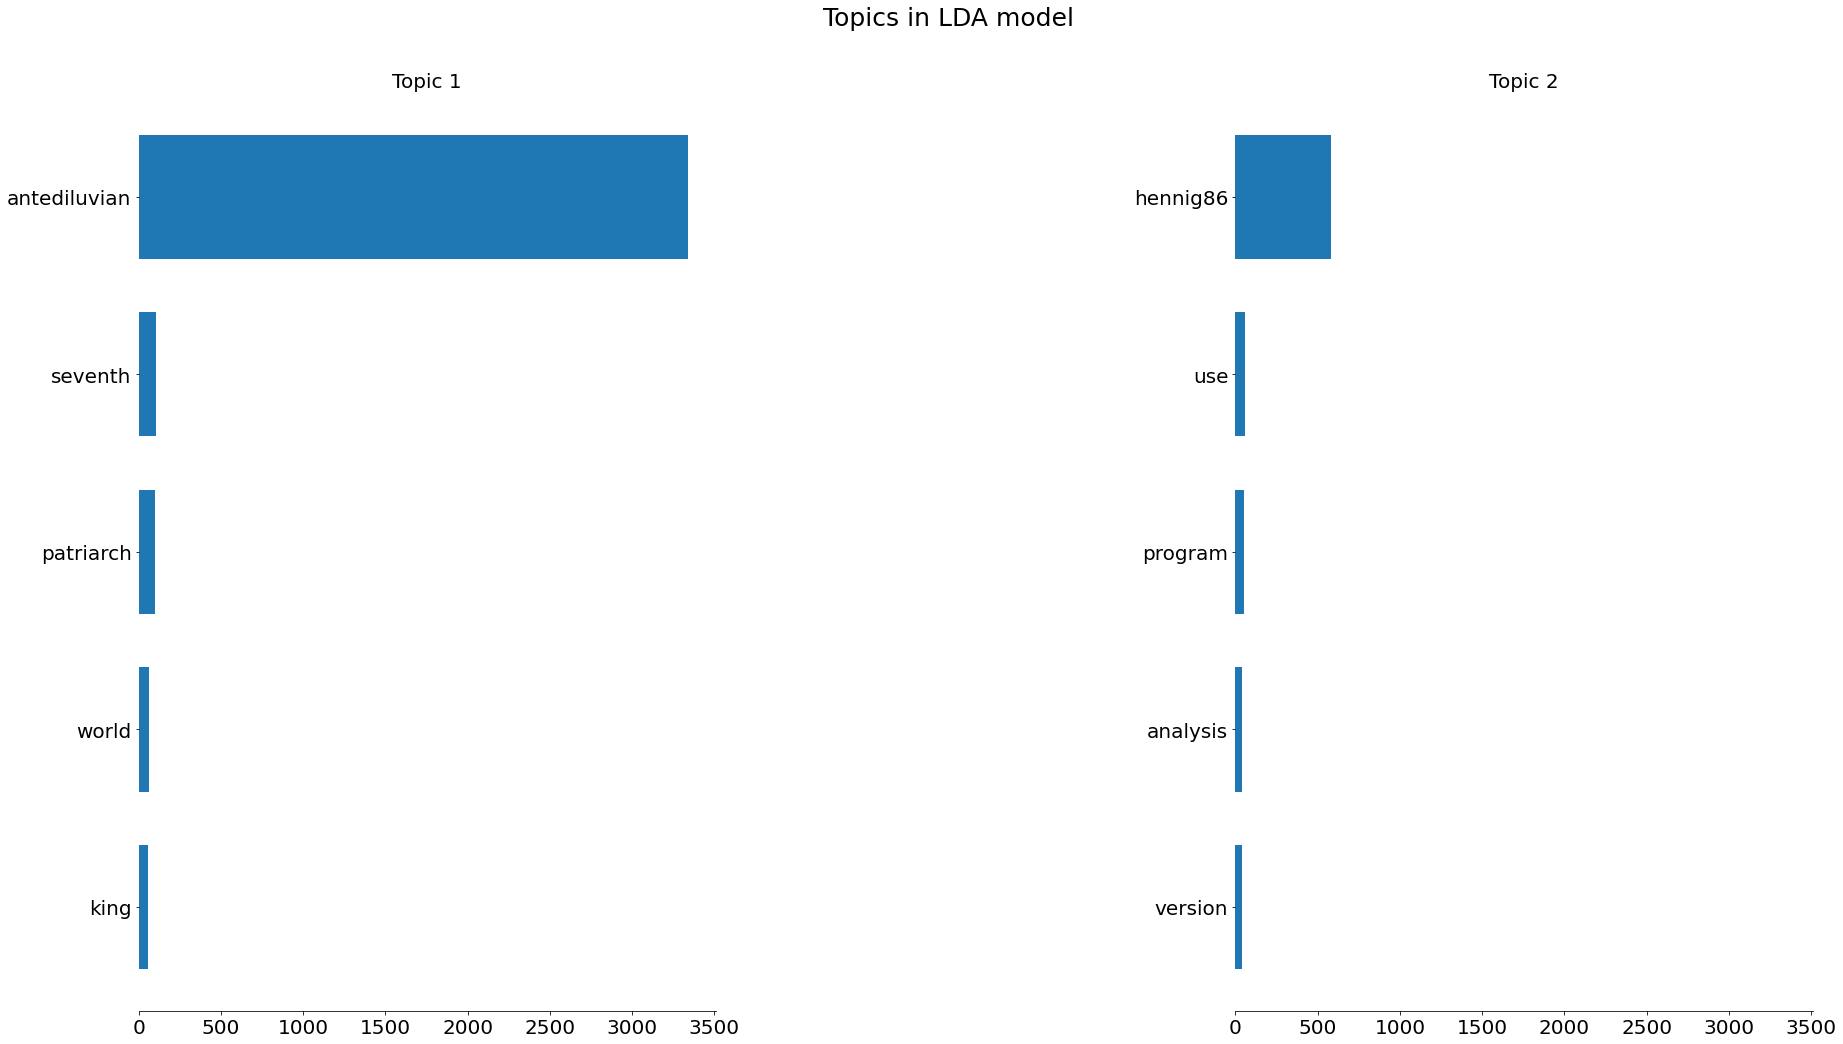

In [36]:
# on the tagged, preprocessed ngrams fed into the CountVectorizer
numTopics = 2 # hyperparameter
X = countVec
lda = LDA(n_components=numTopics, random_state=1)

print("Fitting Corpus...")
t0 = time()
Xpred = lda.fit_transform(X)
print("done in %0.3fs.\n" % (time() - t0))

XpredDict = {}
probDict = {}
y = []
cols = vectorizer.get_feature_names_out()

plot_top_words(lda, cols, n_top_words=5, title="Topics in LDA model", n_topics=numTopics)

# figure out a way to note which hashes belong to which topics

In [ ]:
# observations:
#
# the model is decent at pulling apart the two topics: hennig86 and antedivulian. 
# occassionally makes the two topics both antedivulian with one having the hennig86 feature. 
# given the minimal overlap between the two datasets, a reasonable model should be able to pick apart the differences. 
# the size discrepancies between the two datasets make be the reason for this mistake.

**Performance Testing**

In [27]:
# https://github.com/derekgreene/topic-model-tutorial/blob/master/3%20-%20Parameter%20Selection%20for%20NMF.ipynb

def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.wv.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

Applying LDA for k=1 ...
Applying LDA for k=2 ...
Applying LDA for k=3 ...
Applying LDA for k=4 ...
Applying LDA for k=5 ...
Applying LDA for k=6 ...
Applying LDA for k=7 ...
Applying LDA for k=8 ...
Applying LDA for k=9 ...
Applying LDA for k=10 ...
Applying LDA for k=11 ...
Applying LDA for k=12 ...
Applying LDA for k=13 ...
Applying LDA for k=14 ...
Applying LDA for k=15 ...
Applying LDA for k=16 ...
Applying LDA for k=17 ...
Applying LDA for k=18 ...
Applying LDA for k=19 ...
Applying LDA for k=20 ...
K=01: Coherence=0.9693 Information=0.0078
K=02: Coherence=0.9808 Information=0.6232
K=03: Coherence=0.9797 Information=0.3927
K=04: Coherence=0.9911 Information=0.8113
K=05: Coherence=0.9536 Information=0.9414
K=06: Coherence=0.9915 Information=1.1506
K=07: Coherence=0.9866 Information=1.2135
K=08: Coherence=0.9133 Information=1.5064
K=09: Coherence=0.9730 Information=1.7025
K=10: Coherence=0.9747 Information=1.8316
K=11: Coherence=0.9418 Information=1.9752
K=12: Coherence=0.8635 Info

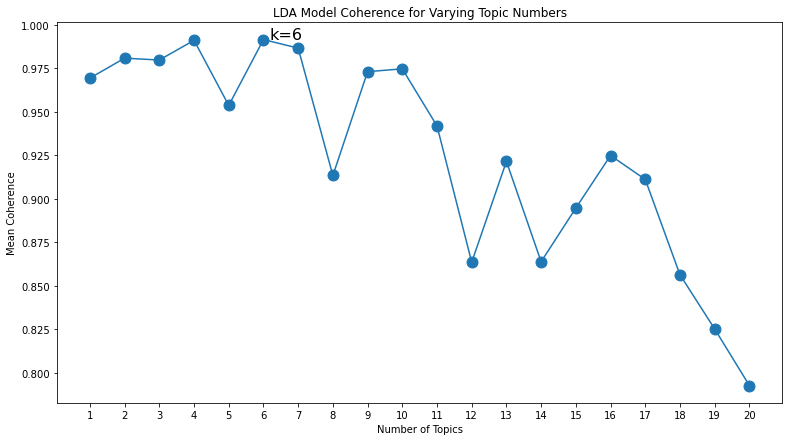

Text(0.5, 1.0, 'LDA Model Information Gain for Varying Topic Numbers')

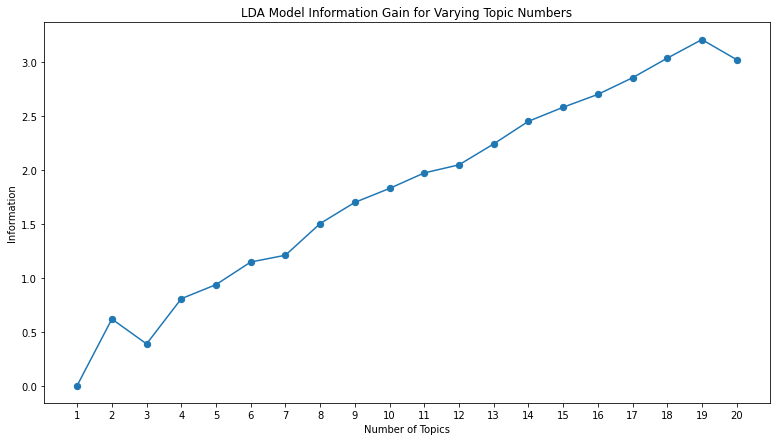

In [37]:
# https://stackoverflow.com/questions/46752650/information-gain-calculation-with-scikit-learn
X = countVec
Y = np.array(df["topic_num"])

res = dict(zip(terms, mutual_info_classif(X, Y)))

A = TfIdf
kmin, kmax = 1, 20

LDA_topic_models = []
# try each value of k
for k in range(kmin,kmax+1):

    print("Applying LDA for k=%d ..." % k )
    # run LDA
    model = LDA( n_components=k , max_iter=10)
    W = model.fit_transform( A )
    H = model.components_
    # store for later
    LDA_topic_models.append( (k,W,H) )

k_values = []
coherences = []
information = []
for (k,W,H) in LDA_topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )

    # https://stackoverflow.com/questions/46752650/information-gain-calculation-with-scikit-learn
    Y = np.array(df["topic_num"])

    res = dict(zip(terms, mutual_info_classif(W, Y)))
    entropy = np.sum(np.fromiter(res.values(), dtype=float))
    information.append(entropy)
    print("K=%02d: Coherence=%.4f Information=%.4f" % ( k, coherences[-1], information[-1] ) )
    

fig = plt.figure(figsize=(13,7))
# create the line plot
ax_coherence = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter(k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate("k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
plt.title("LDA Model Coherence for Varying Topic Numbers")
# show the plot
plt.show()

# information gain plot
fig = plt.figure(figsize=(13,7))
ax_information = plt.plot( k_values, information )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Information")
# add the points
plt.scatter(k_values, information, s=40)
plt.title("LDA Model Information Gain for Varying Topic Numbers")

##### NMF Model

c:\Users\ianha\conda\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


done in 0.051s.


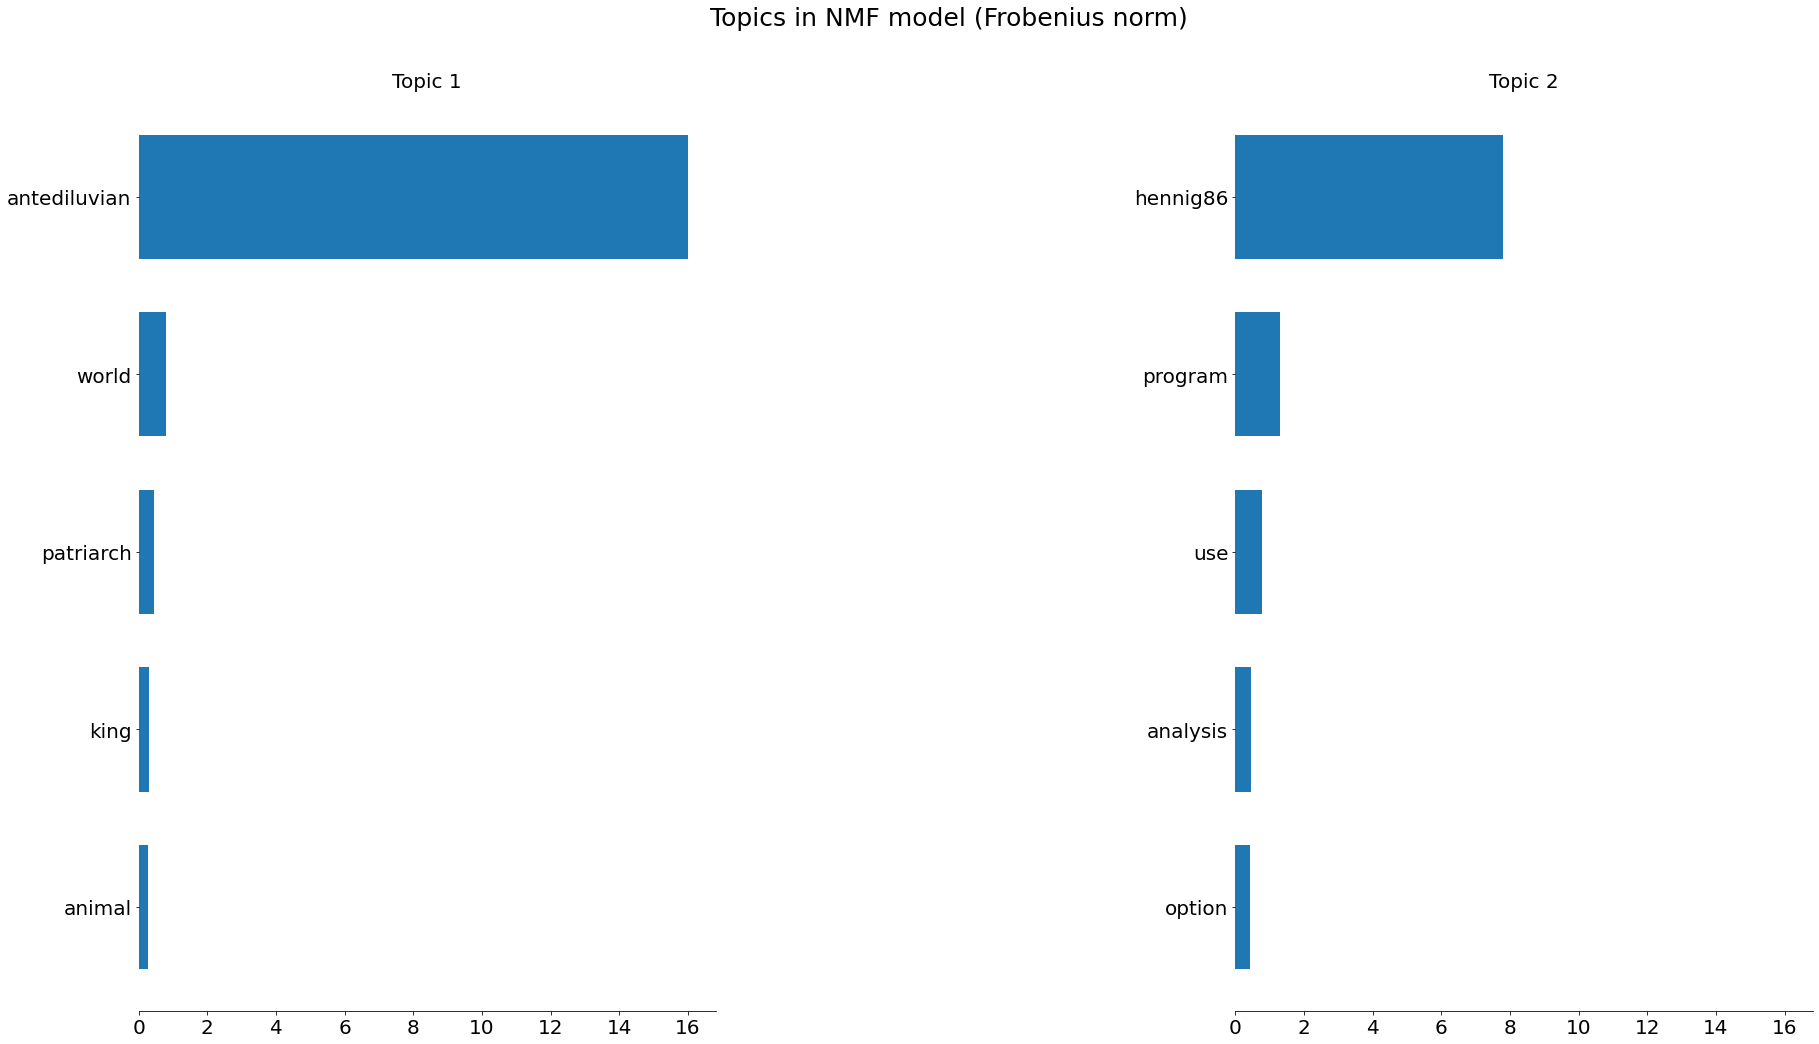

done in 0.027s.


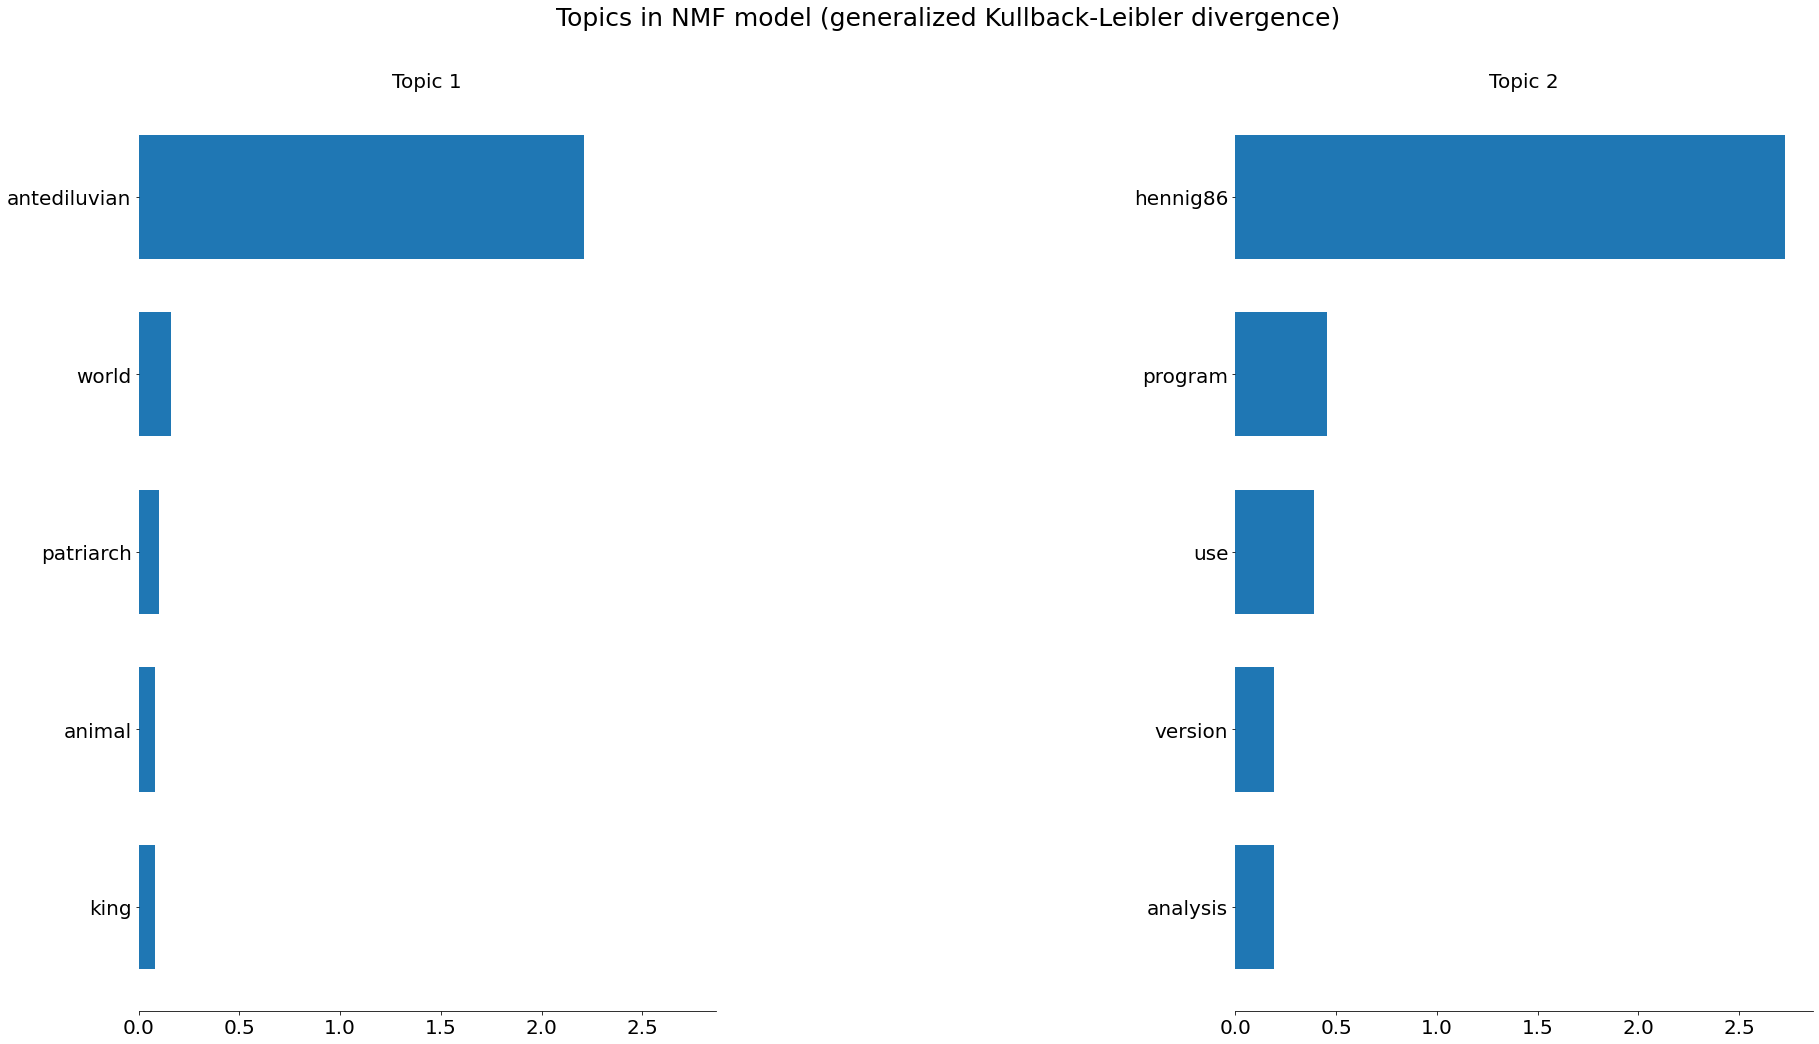

In [26]:
# takes in TF-IDF matrix
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
n_components = 2

# Fit the NMF model
t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init="nndsvda",
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(TfIdf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf, tfidf_feature_names, n_top_words=5, title="Topics in NMF model (Frobenius norm)", n_topics=n_components
)

# Fit the NMF model
t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init="nndsvda",
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(TfIdf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words=5,
    title="Topics in NMF model (generalized Kullback-Leibler divergence)", n_topics=n_components
)

**Performance Testing**

##### Top2Vec Model

In [11]:
# import tensorflow_hub as hub
# embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
top2vec = Top2Vec(documents=list(df["ngram_lc_doc"]))

2022-07-19 22:46:14,611 - top2vec - INFO - Pre-processing documents for training
2022-07-19 22:46:14,667 - top2vec - INFO - Creating joint document/word embedding
2022-07-19 22:46:15,658 - top2vec - INFO - Creating lower dimension embedding of documents
2022-07-19 22:46:22,568 - top2vec - INFO - Finding dense areas of documents
2022-07-19 22:46:22,592 - top2vec - INFO - Finding topics


##### BERTopic Model

In [11]:
# very broken rip, figure out conflict (probably tensorflow)

# test embedding models and other hyperparameters
bertopic_model = BERTopic(verbose=True, embedding_model="all-MiniLM-L6-v2" ,min_topic_size=3)
topics, _ = bertopic_model.fit_transform(df["ngram_lc_doc"])

: 

: 

In [22]:
bertopic_model.get_topic_info()

NameError: name 'bertopic_model' is not defined

### Performance Testing

In [ ]:
"""from timeit import Timer
funcList = ["buildAdjacencyMatrixByColumn", "buildAdjacencyListByColumn"]
parameterList = ["ngram_lc"]
numTests = 100

testingDict = {}
for func in funcList:
    thisTest = {}
    for param in parameterList:
        funcString = func + "(df, \"" + param + "\")"
        importString = "from __main__ import " + func + " , df"
        t = Timer(funcString, importString)
        testTime = t.timeit(number=numTests)
        thisTest["compute time (seconds)"] = testTime / numTests
    testingDict[func] = thisTest

testingDict["buildAdjacencyMatrixByColumn"]["storage (bytes)"] = sys.getsizeof(buildAdjacencyMatrixByColumn(df, parameterList[0]))
testingDict["buildAdjacencyListByColumn"]["storage (bytes)"] = sys.getsizeof(buildAdjacencyListByColumn(df, parameterList[0]))

testDF = pd.DataFrame(testingDict)
testDF.to_csv("performance testing 100 iterations.csv")
# storage in memory in bytes
# compute time in seconds
testDF
"""

In [21]:
# the above code generated this data
pd.read_csv("performance testing 100 iterations simple numSimilar.csv", index_col="Unnamed: 0")

,buildAdjacencyMatrixByColumn,buildAdjacencyListByColumn
compute time (seconds),3.748518e+00,3.754636
storage (bytes),4.718704e+06,36960.000000


In [51]:
# https://github.com/biolab/orange3/blob/master/Orange/preprocess/score.py#L233

def _entropy(dist):
    """Entropy of class-distribution matrix"""
    p = dist / np.sum(dist, axis=0)
    pc = np.clip(p, 1e-15, 1)
    return np.sum(np.sum(- p * np.log2(pc), axis=0) * np.sum(dist, axis=0) / np.sum(dist))


class GainRatio():
    """
    Information gain ratio is the ratio between information gain and
    the entropy of the feature's
    value distribution. The score was introduced in [Quinlan1986]_
    to alleviate overestimation for multi-valued features. See `Wikipedia entry on gain ratio
    <http://en.wikipedia.org/wiki/Information_gain_ratio>`_.
    .. [Quinlan1986] J R Quinlan: Induction of Decision Trees, Machine Learning, 1986.
    """
    def from_contingency(self, cont, nan_adjustment):
        h_class = _entropy(np.sum(cont, axis=1))
        h_residual = _entropy(np.compress(np.sum(cont, axis=0), cont, axis=1))
        h_attribute = _entropy(np.sum(cont, axis=0))
        if h_attribute == 0:
            h_attribute = 1
        return nan_adjustment * (h_class - h_residual) / h_attribute

In [74]:
# https://stackoverflow.com/questions/46752650/information-gain-calculation-with-scikit-learn
X = TfIdf
Y = np.array(df["topic_num"])

res = dict(zip(terms, mutual_info_classif(X, Y)))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering m

dict_values([0.002686576059685527, 0.00017787413613771022, 0.0003559969539587912, 0.00017787413613771022, 0.002686576059685527, 0.002686576059685527, 0.00017787413613771022, 0.00017787413613771022, 0.00017787413613771022, 0.00017787413613771022, 0.002686576059685527, 0.002686576059685527, 0.00017787413613771022, 0.0003559969539587912, 0.00017787413613771022, 0.00017787413613771022, 0.002686576059685527, 0.0003559969539587912, 0.00017787413613771022, 0.00017787413613771022, 0.00017787413613771022, 0.00017787413613771022, 0.00017787413613771022, 0.002686576059685527, 0.00017787413613771022, 0.00017787413613771022, 0.00017787413613771022, 0.002686576059685527, 0.00017787413613771022, 0.00017787413613771022, 0.00017787413613771022, 0.0012503657811696288, 0.00017787413613771022, 0.00017787413613771022, 0.00017787413613771022, 0.002686576059685527, 0.00017787413613771022, 0.00017787413613771022, 0.002686576059685527, 0.00017787413613771022, 0.00017787413613771022, 0.00017787413613771022, 0.0

In [80]:
np.sum(np.fromiter(res.values(), dtype=float))

2.9553728521314357

In [70]:
A = TfIdf
kmin, kmax = 1, 20
NMF_topic_models = []
LDA_topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    print("Applying NMF for k=%d ..." % k )
    # run NMF
    model = NMF( init="nndsvd", n_components=k , max_iter=1000)
    W = model.fit_transform( A )
    H = model.components_
    # store for later
    NMF_topic_models.append( (k,W,H) )

    print("Applying LDA for k=%d ..." % k )
    # run LDA
    model = LDA( n_components=k , max_iter=10)
    W = model.fit_transform( A )
    H = model.components_
    # store for later
    LDA_topic_models.append( (k,W,H) )

Applying NMF for k=2 ...
Applying LDA for k=2 ...
Applying NMF for k=3 ...
Applying LDA for k=3 ...
Applying NMF for k=4 ...
Applying LDA for k=4 ...
Applying NMF for k=5 ...
Applying LDA for k=5 ...
Applying NMF for k=6 ...
Applying LDA for k=6 ...
Applying NMF for k=7 ...
Applying LDA for k=7 ...
Applying NMF for k=8 ...
Applying LDA for k=8 ...
Applying NMF for k=9 ...
Applying LDA for k=9 ...
Applying NMF for k=10 ...
Applying LDA for k=10 ...
Applying NMF for k=11 ...
Applying LDA for k=11 ...
Applying NMF for k=12 ...
Applying LDA for k=12 ...
Applying NMF for k=13 ...
Applying LDA for k=13 ...
Applying NMF for k=14 ...
Applying LDA for k=14 ...
Applying NMF for k=15 ...
Applying LDA for k=15 ...
Applying NMF for k=16 ...
Applying LDA for k=16 ...
Applying NMF for k=17 ...
Applying LDA for k=17 ...
Applying NMF for k=18 ...
Applying LDA for k=18 ...
Applying NMF for k=19 ...
Applying LDA for k=19 ...
Applying NMF for k=20 ...
Applying LDA for k=20 ...


K=02: Coherence=0.9992 Information=0.4743
K=03: Coherence=0.9990 Information=0.4144
K=04: Coherence=0.9972 Information=0.3657
K=05: Coherence=0.9988 Information=0.6692
K=06: Coherence=0.9587 Information=0.7416
K=07: Coherence=0.9725 Information=0.7967
K=08: Coherence=0.9601 Information=0.8367
K=09: Coherence=0.9736 Information=0.9040
K=10: Coherence=0.9772 Information=0.8961
K=11: Coherence=0.9707 Information=1.1521
K=12: Coherence=0.9679 Information=1.2343
K=13: Coherence=0.9715 Information=1.3060
K=14: Coherence=0.9482 Information=1.3017
K=15: Coherence=0.9340 Information=1.4599
K=16: Coherence=0.9390 Information=1.4299
K=17: Coherence=0.9193 Information=1.4197
K=18: Coherence=0.9488 Information=1.6837
K=19: Coherence=0.9092 Information=1.7180
K=20: Coherence=0.9101 Information=1.4596


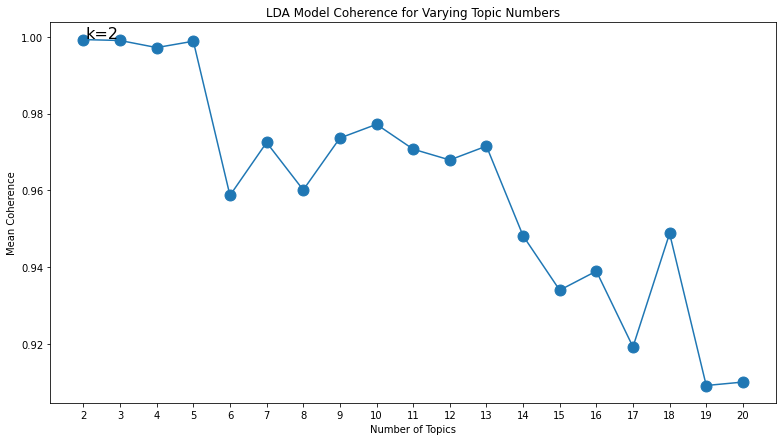

Text(0.5, 1.0, 'LDA Model Information Gain for Varying Topic Numbers')

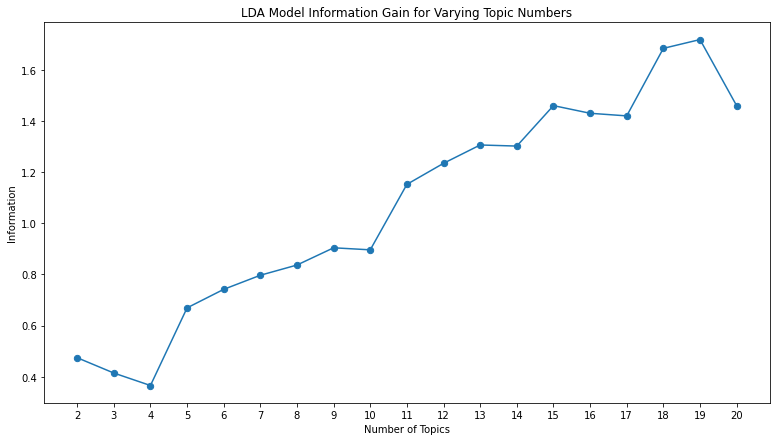

In [88]:
k_values = []
coherences = []
information = []
for (k,W,H) in LDA_topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )

    # https://stackoverflow.com/questions/46752650/information-gain-calculation-with-scikit-learn
    Y = np.array(df["topic_num"])

    res = dict(zip(terms, mutual_info_classif(W, Y)))
    entropy = np.sum(np.fromiter(res.values(), dtype=float))
    information.append(entropy)
    print("K=%02d: Coherence=%.4f Information=%.4f" % ( k, coherences[-1], information[-1] ) )
    

fig = plt.figure(figsize=(13,7))
# create the line plot
ax_coherence = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter(k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate("k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
plt.title("LDA Model Coherence for Varying Topic Numbers")
# show the plot
plt.show()

# information gain plot
fig = plt.figure(figsize=(13,7))
ax_information = plt.plot( k_values, information )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Information")
# add the points
plt.scatter(k_values, information, s=40)
plt.title("LDA Model Information Gain for Varying Topic Numbers")


K=02: Coherence=0.9991 Information=0.7175
K=03: Coherence=0.9987 Information=0.7327
K=04: Coherence=0.9938 Information=0.7563
K=05: Coherence=0.9769 Information=0.7503
K=06: Coherence=0.8728 Information=0.7669
K=07: Coherence=0.8834 Information=0.7656
K=08: Coherence=0.8865 Information=0.7817
K=09: Coherence=0.8770 Information=0.8019
K=10: Coherence=0.8612 Information=0.8030
K=11: Coherence=0.8875 Information=0.8117
K=12: Coherence=0.8831 Information=0.8067
K=13: Coherence=0.9027 Information=0.8789
K=14: Coherence=0.9085 Information=0.8639
K=15: Coherence=0.8939 Information=0.8924
K=16: Coherence=0.9003 Information=0.9612
K=17: Coherence=0.9058 Information=1.0231
K=18: Coherence=0.9020 Information=0.9945
K=19: Coherence=0.8950 Information=1.0296
K=20: Coherence=0.8919 Information=0.9911


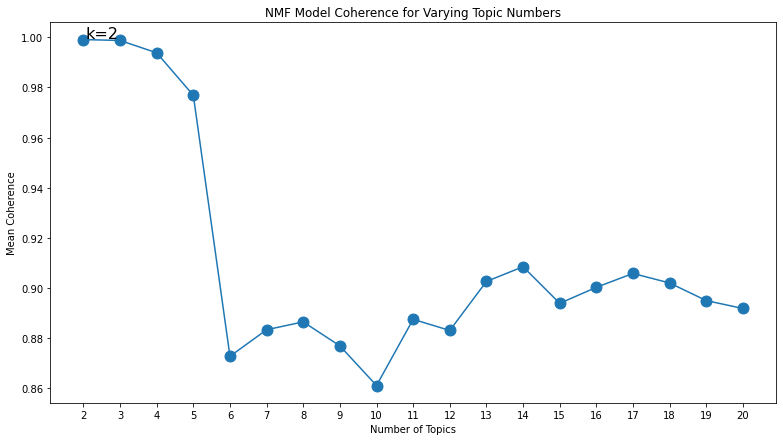

Text(0.5, 1.0, 'NMF Model Information Gain for Varying Topic Numbers')

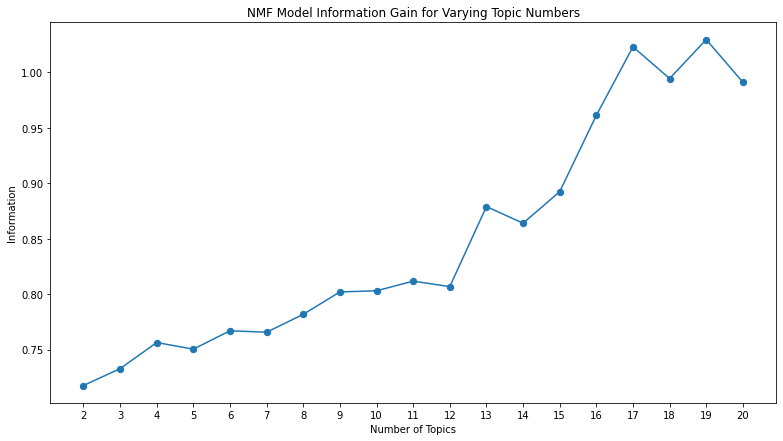

In [89]:
k_values = []
coherences = []
information = []
for (k,W,H) in NMF_topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    Y = np.array(df["topic_num"])

    res = dict(zip(terms, mutual_info_classif(W, Y)))
    entropy = np.sum(np.fromiter(res.values(), dtype=float))
    information.append(entropy)
    print("K=%02d: Coherence=%.4f Information=%.4f" % ( k, coherences[-1], information[-1] ) )

fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter(k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate("k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
plt.title("NMF Model Coherence for Varying Topic Numbers")
# show the plot
plt.show()


# information gain plot
fig = plt.figure(figsize=(13,7))
ax_information = plt.plot( k_values, information )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Information")
# add the points
plt.scatter(k_values, information, s=40)
plt.title("NMF Model Information Gain for Varying Topic Numbers")

### Building Networks and Partitioning Communities
Test different ways to partition communities (including by topic). Find other ways to quantify or analyze the network before full-scale visualization.

In [22]:
# initial community partition

# column to build adajency matrix 
adjColumnName = "ngram_lc_nounsverbs"
adjColumnNameDoc = "ngram_lc_nounverbs_doc"

print("Building numSimilar() Adjacency Matrix...")
t0 = time()
adjMatrixNumSimilar = buildAdjacencyMatrixByColumn(df, adjColumnName) # number similar strings
# cosine similarity
# euclidean distance
print("Done in %0.3fs.\n" % (time() - t0))

print("Building word co-occurence Adjacency Matrix...")
t0 = time()
dfBOW = getBackOfWordsDF(df, adjColumnNameDoc)
coocAdjMatrix = buildAdjacencyMatrixByCoOccurence(dfBOW)
print("Done in %0.3fs.\n" % (time() - t0))

print("Building Doc2Vec cosine similarity Adjacency Matrix...")
t0 = time()
T = 0.95 # hyperparameter
cosSimMatrix = buildAdjacencyMatrixByCosineSimilarity(docVectors)
cosSimMatrix[cosSimMatrix < T] = 0
cosSimMatrix[cosSimMatrix >= T] = 1
print("Done in %0.3fs.\n" % (time() - t0))

print("Building Networkx Graphs...")
t0 = time()
Gsim = nx.from_numpy_array(adjMatrixNumSimilar)
Gcossim = nx.from_numpy_array(cosSimMatrix)
Gcooc = nx.from_numpy_array(coocAdjMatrix)
print("Done in %0.3fs.\n" % (time() - t0))

community_generator = nx.algorithms.community

print("Building Louvain Partitions...")
t0 = time()
communitySetsNumSimilar = community_generator.louvain_communities(Gsim, resolution=0.1)
communitySetsCossineSim = community_generator.louvain_communities(Gcossim, resolution=0.1)
communitySetsCooc = community_generator.louvain_communities(Gcooc, resolution=0.1)
print("Done in %0.3fs.\n" % (time() - t0))

print("Adding Node Metadata...")
t0 = time()
graphList = [(adjMatrixNumSimilar, Gsim, communitySetsNumSimilar, "numSimilar()"), (coocAdjMatrix, Gcooc, communitySetsCooc, "co-occurence"), (cosSimMatrix, Gcossim, communitySetsCossineSim, "vector cosine similarity")]
for graphs in graphList:
    print("Beginning " + graphs[3] + "...\n")
    numCommunities = 0
    numNodes = len(df)
    nodes = list(range(numNodes))
    scalingFactor = 5. # scales the node size for visibility
    communitySets = graphs[2]
    G = graphs[1]
    adjMatrix = graphs[0]

    node_to_community = {}

    for set in communitySets:
        for x in set:
            node_to_community[x] = numCommunities
        numCommunities = numCommunities + 1

    for n in nodes:
        # 'title': hash (i.e. dataframe index)
        # 'group': partition
        # 'value': topic (empty for now)
        # 'size': normalized YAKE score
        G.nodes[n]["title"] = df.index[n] # this (clearly) doesn't work for matrices based on words (e.g. cooccurence)
        G.nodes[n]["group"] = node_to_community[n]
        G.nodes[n]["size"] = df["normalized_term_freq"][n] * scalingFactor

    # remove nodes apart of sparse communities

    community_sets_pared = []
    X = 3

    for com in communitySets:
        if (len(com) < X): # bypasses communities with fewer than X nodes
            continue
        else:
            community_sets_pared.append(com)

    nodes_to_keep = list(itertools.chain(*community_sets_pared))

    print("Adjacency Matrix size before: " + str(adjMatrix.shape))
    adjMatrixReduced = (adjMatrix[nodes_to_keep].T)[nodes_to_keep].T  # https://stackoverflow.com/questions/22927181/selecting-specific-rows-and-columns-from-numpy-array
    print("Adjacency Matrix size after: " + str(adjMatrixReduced.shape))

    nodes_to_remove = subtractListsOfInts(nodes, nodes_to_keep)
    G.remove_nodes_from(nodes_to_remove)

    numCommunitiesRemoved = numCommunities - len(community_sets_pared)
    print("Number of communities removed: " + str(numCommunitiesRemoved))

    numCommunities = numCommunities - numCommunitiesRemoved
    print("Number of communities remaining: " + str(numCommunities) + "\n")
print("Done in %0.3fs.\n" % (time() - t0))

Building numSimilar() Adjacency Matrix...
Done in 4.258s.

Building word co-occurence Adjacency Matrix...
Done in 3.563s.

Building Doc2Vec cosine similarity Adjacency Matrix...
Done in 5.188s.

Building Networkx Graphs...
Done in 0.120s.

Building Louvain Partitions...
Done in 0.347s.

Adding Node Metadata...
Beginning numSimilar()...

Adjacency Matrix size before: (768, 768)
Adjacency Matrix size after: (594, 594)
Number of communities removed: 160
Number of communities remaining: 8

Beginning co-occurence...

Adjacency Matrix size before: (1343, 1343)
Adjacency Matrix size after: (1317, 1317)
Number of communities removed: 18
Number of communities remaining: 8

Beginning vector cosine similarity...

Adjacency Matrix size before: (768, 768)
Adjacency Matrix size after: (651, 651)
Number of communities removed: 107
Number of communities remaining: 3

Done in 0.044s.

